# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

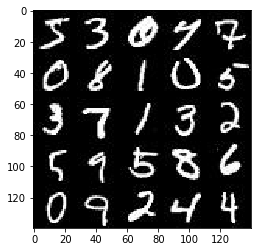

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

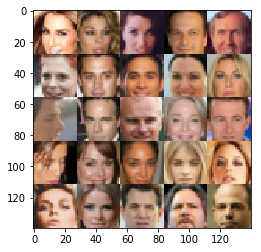

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="inputs_real")
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name="inputs_z")
    learn_rate = tf.placeholder(tf.float32, name="learn_rate")
    
    return inputs_real, inputs_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope("discriminator", reuse=reuse):
        # First layer - No batch normalization. Images = 28x28
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding="same")
        x1 = tf.maximum(alpha * x1, x1)
        # Now 14x14
        
        x2 = tf.layers.conv2d(x1, 256, 5, strides=2, padding="same")
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        # Now 7x7
        
        x3 = tf.layers.conv2d(x2, 512, 5, strides=2, padding="same")
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        # Now 4x4
    
        flat = tf.reshape(x3, (-1, 4*4*512))
        
        logits = tf.layers.dense(flat, 1)
        output = tf.nn.sigmoid(logits)

        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [17]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = 0.2
    
    with tf.variable_scope("generator", reuse=not is_train):
        # Input layer to fully connected and reshape        
        fc1 = tf.layers.dense(z, 4*4*512)
        fc1 = tf.reshape(fc1, (-1, 4, 4, 512))
        fc1 = tf.layers.batch_normalization(fc1, training=is_train)
        fc1 = tf.maximum(alpha * fc1, fc1)
        
        # Conv layers start here
        x1 = tf.layers.conv2d_transpose(fc1, 256, 4, strides=1, padding="valid")
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # Now 7x7
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding="same")
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # Now 14x14
        
        x3 = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding="same")
        # Now 28x28
        
        output = tf.nn.tanh(x3)

        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [18]:
def model_loss(inputs_real, inputs_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_output = generator(inputs_z, out_channel_dim)
    d_output_real, d_logits_real = discriminator(inputs_real)
    d_output_fake, d_logits_fake = discriminator(g_output, reuse=True)          
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
        
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [19]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    train_var = tf.trainable_variables()
    g_var = [var for var in train_var if var.name.startswith("generator")]
    d_var = [var for var in train_var if var.name.startswith("discriminator")]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_var)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_var)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [20]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [21]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    #saver = tf.train.Saver()
    steps = 0
    
    _, image_width, image_height, image_channels = data_shape
        
    # Build the network
    inputs_real, inputs_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)    
    d_loss, g_loss = model_loss(inputs_real, inputs_z, image_channels)    
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                
                # Create random noise inputs for generator. 1 per batch_size for 1:1 ratio
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images,
                                                     inputs_z: batch_z,
                                                     learn_rate: learning_rate})
                
                _ = sess.run(g_train_opt, feed_dict={inputs_real: batch_images,
                                                     inputs_z: batch_z,
                                                     learn_rate: learning_rate})
                
                # Every 10 steps, print losses
                if steps % 10 == 0:
                    # Every 10 steps, get the losses and print them out
                    train_loss_d = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images, learn_rate: learning_rate})
                    train_loss_g = g_loss.eval({inputs_z: batch_z, learn_rate: learning_rate})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                # Every 100 steps, print sample images
                if steps % 100 == 0:
                    show_generator_output(sess, 25, inputs_z, image_channels, data_image_mode)                
        
        #saver.save(sess, './checkpoints/generator.ckpt')


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0225... Generator Loss: 6.2231
Epoch 1/2... Discriminator Loss: 0.0512... Generator Loss: 20.9132
Epoch 1/2... Discriminator Loss: 0.1511... Generator Loss: 23.6483
Epoch 1/2... Discriminator Loss: 0.0981... Generator Loss: 2.6094
Epoch 1/2... Discriminator Loss: 2.7458... Generator Loss: 0.1761
Epoch 1/2... Discriminator Loss: 3.4711... Generator Loss: 0.0469
Epoch 1/2... Discriminator Loss: 0.0276... Generator Loss: 11.6658
Epoch 1/2... Discriminator Loss: 0.1662... Generator Loss: 3.5650
Epoch 1/2... Discriminator Loss: 0.0763... Generator Loss: 6.0958
Epoch 1/2... Discriminator Loss: 0.4898... Generator Loss: 2.1356


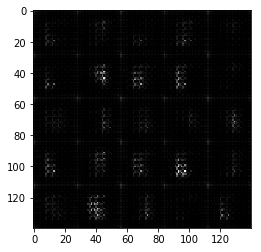

Epoch 1/2... Discriminator Loss: 0.3403... Generator Loss: 1.6739
Epoch 1/2... Discriminator Loss: 1.0719... Generator Loss: 11.9516
Epoch 1/2... Discriminator Loss: 0.3523... Generator Loss: 11.0705
Epoch 1/2... Discriminator Loss: 0.3531... Generator Loss: 1.8716
Epoch 1/2... Discriminator Loss: 0.2028... Generator Loss: 3.3621
Epoch 1/2... Discriminator Loss: 1.1382... Generator Loss: 1.2175
Epoch 1/2... Discriminator Loss: 0.6997... Generator Loss: 1.1142
Epoch 1/2... Discriminator Loss: 0.5729... Generator Loss: 3.4707
Epoch 1/2... Discriminator Loss: 1.5899... Generator Loss: 0.4792
Epoch 1/2... Discriminator Loss: 0.8766... Generator Loss: 1.4593


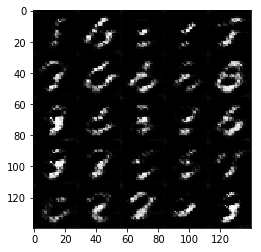

Epoch 1/2... Discriminator Loss: 0.4976... Generator Loss: 2.4965
Epoch 1/2... Discriminator Loss: 0.8010... Generator Loss: 1.6460
Epoch 1/2... Discriminator Loss: 0.7284... Generator Loss: 1.1489
Epoch 1/2... Discriminator Loss: 0.7272... Generator Loss: 0.9468
Epoch 1/2... Discriminator Loss: 1.6057... Generator Loss: 0.5130
Epoch 1/2... Discriminator Loss: 0.9184... Generator Loss: 2.3493
Epoch 1/2... Discriminator Loss: 0.7303... Generator Loss: 2.3048
Epoch 1/2... Discriminator Loss: 1.5491... Generator Loss: 0.4811
Epoch 1/2... Discriminator Loss: 0.8499... Generator Loss: 1.4511
Epoch 1/2... Discriminator Loss: 0.5862... Generator Loss: 1.9164


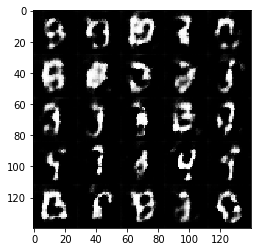

Epoch 1/2... Discriminator Loss: 0.2481... Generator Loss: 2.6142
Epoch 1/2... Discriminator Loss: 0.7470... Generator Loss: 2.3085
Epoch 1/2... Discriminator Loss: 1.0288... Generator Loss: 0.7436
Epoch 1/2... Discriminator Loss: 0.7471... Generator Loss: 1.4758
Epoch 1/2... Discriminator Loss: 0.9467... Generator Loss: 2.3114
Epoch 1/2... Discriminator Loss: 0.4090... Generator Loss: 2.9939
Epoch 1/2... Discriminator Loss: 0.7885... Generator Loss: 1.6260
Epoch 1/2... Discriminator Loss: 1.3252... Generator Loss: 0.4783
Epoch 1/2... Discriminator Loss: 1.3467... Generator Loss: 0.5783
Epoch 1/2... Discriminator Loss: 1.0882... Generator Loss: 0.8725


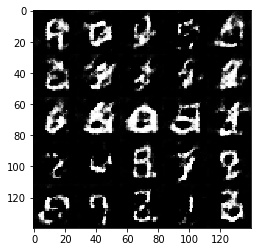

Epoch 1/2... Discriminator Loss: 1.4798... Generator Loss: 2.7641
Epoch 1/2... Discriminator Loss: 1.4280... Generator Loss: 1.5637
Epoch 1/2... Discriminator Loss: 0.9164... Generator Loss: 2.0006
Epoch 1/2... Discriminator Loss: 0.7246... Generator Loss: 1.3346
Epoch 1/2... Discriminator Loss: 0.7283... Generator Loss: 1.3646
Epoch 1/2... Discriminator Loss: 0.9027... Generator Loss: 1.9766
Epoch 1/2... Discriminator Loss: 0.8027... Generator Loss: 1.7188
Epoch 1/2... Discriminator Loss: 1.2423... Generator Loss: 0.6851
Epoch 1/2... Discriminator Loss: 0.8713... Generator Loss: 0.9080
Epoch 1/2... Discriminator Loss: 0.9775... Generator Loss: 0.8006


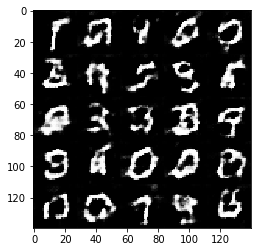

Epoch 1/2... Discriminator Loss: 1.1042... Generator Loss: 0.8253
Epoch 1/2... Discriminator Loss: 1.1896... Generator Loss: 0.5858
Epoch 1/2... Discriminator Loss: 1.4091... Generator Loss: 2.9763
Epoch 1/2... Discriminator Loss: 0.6461... Generator Loss: 1.4932
Epoch 1/2... Discriminator Loss: 1.1848... Generator Loss: 2.7096
Epoch 1/2... Discriminator Loss: 0.8419... Generator Loss: 1.4222
Epoch 1/2... Discriminator Loss: 0.9129... Generator Loss: 1.0339
Epoch 1/2... Discriminator Loss: 0.7390... Generator Loss: 1.1475
Epoch 1/2... Discriminator Loss: 0.8255... Generator Loss: 1.8346
Epoch 1/2... Discriminator Loss: 1.0778... Generator Loss: 2.8775


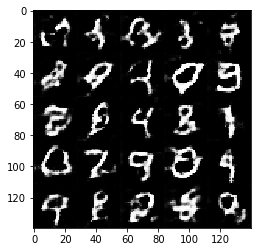

Epoch 1/2... Discriminator Loss: 0.9997... Generator Loss: 1.2071
Epoch 1/2... Discriminator Loss: 0.7861... Generator Loss: 1.7373
Epoch 1/2... Discriminator Loss: 1.0129... Generator Loss: 1.3555
Epoch 1/2... Discriminator Loss: 0.6937... Generator Loss: 1.9976
Epoch 1/2... Discriminator Loss: 0.8790... Generator Loss: 0.9821
Epoch 1/2... Discriminator Loss: 1.0360... Generator Loss: 1.8354
Epoch 1/2... Discriminator Loss: 0.7569... Generator Loss: 1.5182
Epoch 1/2... Discriminator Loss: 1.0126... Generator Loss: 0.9960
Epoch 1/2... Discriminator Loss: 0.7654... Generator Loss: 1.2834
Epoch 1/2... Discriminator Loss: 0.7537... Generator Loss: 1.6837


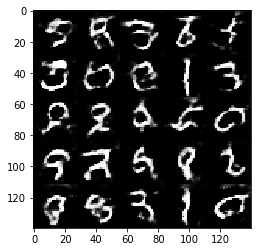

Epoch 1/2... Discriminator Loss: 1.5517... Generator Loss: 0.4696
Epoch 1/2... Discriminator Loss: 1.2995... Generator Loss: 0.5276
Epoch 1/2... Discriminator Loss: 0.8198... Generator Loss: 2.0742
Epoch 1/2... Discriminator Loss: 0.7149... Generator Loss: 1.1910
Epoch 1/2... Discriminator Loss: 0.9451... Generator Loss: 1.9566
Epoch 1/2... Discriminator Loss: 0.8107... Generator Loss: 0.9347
Epoch 1/2... Discriminator Loss: 0.9310... Generator Loss: 2.3780
Epoch 1/2... Discriminator Loss: 0.8123... Generator Loss: 1.6622
Epoch 1/2... Discriminator Loss: 0.9190... Generator Loss: 1.0155
Epoch 1/2... Discriminator Loss: 0.8382... Generator Loss: 0.9494


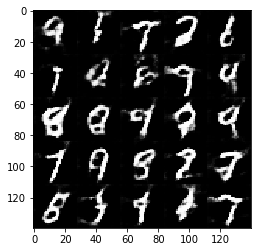

Epoch 1/2... Discriminator Loss: 0.7793... Generator Loss: 1.2768
Epoch 1/2... Discriminator Loss: 0.8261... Generator Loss: 0.9179
Epoch 1/2... Discriminator Loss: 0.8409... Generator Loss: 1.0506
Epoch 1/2... Discriminator Loss: 0.6758... Generator Loss: 1.2663
Epoch 1/2... Discriminator Loss: 0.7333... Generator Loss: 1.6963
Epoch 1/2... Discriminator Loss: 1.7418... Generator Loss: 0.5549
Epoch 1/2... Discriminator Loss: 1.0553... Generator Loss: 1.0164
Epoch 1/2... Discriminator Loss: 0.7723... Generator Loss: 1.1096
Epoch 1/2... Discriminator Loss: 0.8384... Generator Loss: 1.8168
Epoch 1/2... Discriminator Loss: 1.3984... Generator Loss: 0.4376


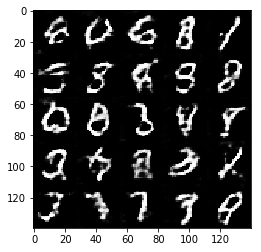

Epoch 1/2... Discriminator Loss: 0.8160... Generator Loss: 1.2274
Epoch 1/2... Discriminator Loss: 0.9322... Generator Loss: 0.9838
Epoch 1/2... Discriminator Loss: 0.8204... Generator Loss: 1.2407
Epoch 2/2... Discriminator Loss: 0.6353... Generator Loss: 1.4843
Epoch 2/2... Discriminator Loss: 0.9104... Generator Loss: 1.1518
Epoch 2/2... Discriminator Loss: 0.8384... Generator Loss: 0.9722
Epoch 2/2... Discriminator Loss: 1.1327... Generator Loss: 0.7764
Epoch 2/2... Discriminator Loss: 1.3980... Generator Loss: 2.3800
Epoch 2/2... Discriminator Loss: 0.8743... Generator Loss: 2.0954
Epoch 2/2... Discriminator Loss: 1.0715... Generator Loss: 1.8996


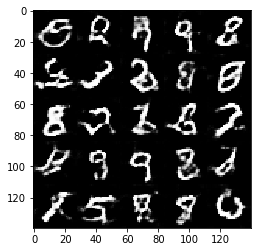

Epoch 2/2... Discriminator Loss: 0.7807... Generator Loss: 1.2764
Epoch 2/2... Discriminator Loss: 0.7480... Generator Loss: 1.3415
Epoch 2/2... Discriminator Loss: 0.8494... Generator Loss: 0.8490
Epoch 2/2... Discriminator Loss: 2.5615... Generator Loss: 0.1375
Epoch 2/2... Discriminator Loss: 0.7645... Generator Loss: 1.1036
Epoch 2/2... Discriminator Loss: 0.9146... Generator Loss: 1.0711
Epoch 2/2... Discriminator Loss: 0.9207... Generator Loss: 1.0307
Epoch 2/2... Discriminator Loss: 1.2296... Generator Loss: 0.5556
Epoch 2/2... Discriminator Loss: 0.7927... Generator Loss: 1.7139
Epoch 2/2... Discriminator Loss: 0.7309... Generator Loss: 1.0262


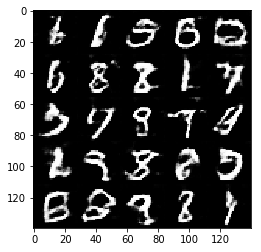

Epoch 2/2... Discriminator Loss: 0.8178... Generator Loss: 1.4462
Epoch 2/2... Discriminator Loss: 0.7421... Generator Loss: 1.6505
Epoch 2/2... Discriminator Loss: 0.5909... Generator Loss: 1.4388
Epoch 2/2... Discriminator Loss: 1.1457... Generator Loss: 0.9841
Epoch 2/2... Discriminator Loss: 0.9342... Generator Loss: 0.7635
Epoch 2/2... Discriminator Loss: 0.7128... Generator Loss: 1.0679
Epoch 2/2... Discriminator Loss: 0.7859... Generator Loss: 1.1284
Epoch 2/2... Discriminator Loss: 0.7214... Generator Loss: 1.3905
Epoch 2/2... Discriminator Loss: 1.5214... Generator Loss: 0.4646
Epoch 2/2... Discriminator Loss: 0.9882... Generator Loss: 1.6095


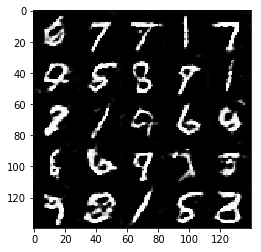

Epoch 2/2... Discriminator Loss: 0.6707... Generator Loss: 1.3699
Epoch 2/2... Discriminator Loss: 0.8409... Generator Loss: 1.9185
Epoch 2/2... Discriminator Loss: 0.7275... Generator Loss: 2.1933
Epoch 2/2... Discriminator Loss: 0.8868... Generator Loss: 0.8940
Epoch 2/2... Discriminator Loss: 2.2282... Generator Loss: 4.4423
Epoch 2/2... Discriminator Loss: 0.8398... Generator Loss: 1.1663
Epoch 2/2... Discriminator Loss: 1.0254... Generator Loss: 0.6781
Epoch 2/2... Discriminator Loss: 1.0347... Generator Loss: 0.6317
Epoch 2/2... Discriminator Loss: 0.6961... Generator Loss: 1.7835
Epoch 2/2... Discriminator Loss: 0.6636... Generator Loss: 1.5484


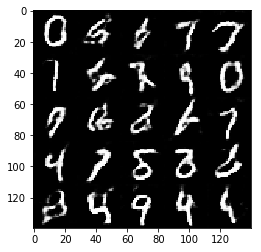

Epoch 2/2... Discriminator Loss: 1.0220... Generator Loss: 1.3299
Epoch 2/2... Discriminator Loss: 0.8407... Generator Loss: 1.6599
Epoch 2/2... Discriminator Loss: 0.6102... Generator Loss: 1.1671
Epoch 2/2... Discriminator Loss: 0.5661... Generator Loss: 1.3888
Epoch 2/2... Discriminator Loss: 1.5478... Generator Loss: 0.3670
Epoch 2/2... Discriminator Loss: 0.8273... Generator Loss: 0.8116
Epoch 2/2... Discriminator Loss: 2.4503... Generator Loss: 0.1866
Epoch 2/2... Discriminator Loss: 1.0771... Generator Loss: 0.7180
Epoch 2/2... Discriminator Loss: 0.4618... Generator Loss: 1.6726
Epoch 2/2... Discriminator Loss: 0.5855... Generator Loss: 1.5899


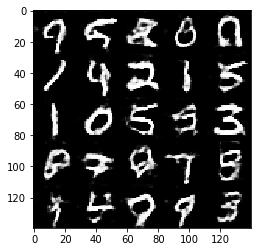

Epoch 2/2... Discriminator Loss: 0.8591... Generator Loss: 0.7753
Epoch 2/2... Discriminator Loss: 0.9639... Generator Loss: 2.8079
Epoch 2/2... Discriminator Loss: 0.8138... Generator Loss: 0.9683
Epoch 2/2... Discriminator Loss: 0.6486... Generator Loss: 1.1215
Epoch 2/2... Discriminator Loss: 4.0575... Generator Loss: 0.0494
Epoch 2/2... Discriminator Loss: 1.0902... Generator Loss: 0.6135
Epoch 2/2... Discriminator Loss: 1.5869... Generator Loss: 0.3639
Epoch 2/2... Discriminator Loss: 1.2672... Generator Loss: 1.2430
Epoch 2/2... Discriminator Loss: 0.6089... Generator Loss: 1.5773
Epoch 2/2... Discriminator Loss: 0.7010... Generator Loss: 1.1168


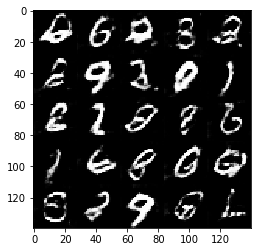

Epoch 2/2... Discriminator Loss: 0.7371... Generator Loss: 0.9307
Epoch 2/2... Discriminator Loss: 0.7929... Generator Loss: 0.7836
Epoch 2/2... Discriminator Loss: 2.6188... Generator Loss: 6.1222
Epoch 2/2... Discriminator Loss: 0.5566... Generator Loss: 2.1895
Epoch 2/2... Discriminator Loss: 1.4633... Generator Loss: 0.3962
Epoch 2/2... Discriminator Loss: 1.3184... Generator Loss: 0.4182
Epoch 2/2... Discriminator Loss: 1.3150... Generator Loss: 0.4761
Epoch 2/2... Discriminator Loss: 0.6587... Generator Loss: 1.0479
Epoch 2/2... Discriminator Loss: 1.0315... Generator Loss: 1.1127
Epoch 2/2... Discriminator Loss: 0.9449... Generator Loss: 0.8244


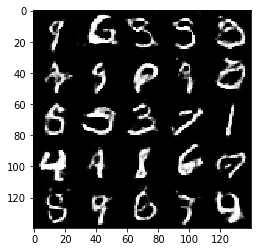

Epoch 2/2... Discriminator Loss: 0.8911... Generator Loss: 0.8728
Epoch 2/2... Discriminator Loss: 0.6023... Generator Loss: 1.8562
Epoch 2/2... Discriminator Loss: 1.4375... Generator Loss: 0.4078
Epoch 2/2... Discriminator Loss: 0.7140... Generator Loss: 1.2082
Epoch 2/2... Discriminator Loss: 0.5790... Generator Loss: 1.2874
Epoch 2/2... Discriminator Loss: 0.9462... Generator Loss: 0.8706
Epoch 2/2... Discriminator Loss: 0.8104... Generator Loss: 0.9723
Epoch 2/2... Discriminator Loss: 0.9545... Generator Loss: 2.5824
Epoch 2/2... Discriminator Loss: 1.1669... Generator Loss: 0.5836
Epoch 2/2... Discriminator Loss: 2.1476... Generator Loss: 0.1838


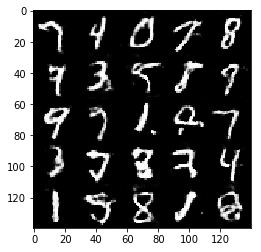

Epoch 2/2... Discriminator Loss: 0.9131... Generator Loss: 1.4049
Epoch 2/2... Discriminator Loss: 0.8988... Generator Loss: 0.8113
Epoch 2/2... Discriminator Loss: 1.6928... Generator Loss: 0.3596
Epoch 2/2... Discriminator Loss: 0.8569... Generator Loss: 0.8395
Epoch 2/2... Discriminator Loss: 0.4905... Generator Loss: 1.8372
Epoch 2/2... Discriminator Loss: 0.5143... Generator Loss: 2.1150
Epoch 2/2... Discriminator Loss: 0.8553... Generator Loss: 1.3587
Epoch 2/2... Discriminator Loss: 1.1005... Generator Loss: 0.6834
Epoch 2/2... Discriminator Loss: 0.5314... Generator Loss: 1.2630
Epoch 2/2... Discriminator Loss: 1.8124... Generator Loss: 0.3406


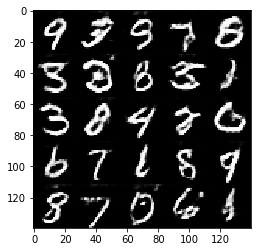

Epoch 2/2... Discriminator Loss: 0.8518... Generator Loss: 0.9764
Epoch 2/2... Discriminator Loss: 1.8528... Generator Loss: 0.2605
Epoch 2/2... Discriminator Loss: 1.3724... Generator Loss: 0.5314
Epoch 2/2... Discriminator Loss: 1.0412... Generator Loss: 0.7751
Epoch 2/2... Discriminator Loss: 0.9217... Generator Loss: 1.0995
Epoch 2/2... Discriminator Loss: 0.6067... Generator Loss: 1.1639
Epoch 2/2... Discriminator Loss: 0.7755... Generator Loss: 0.9787


In [22]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.9125... Generator Loss: 0.2982
Epoch 1/1... Discriminator Loss: 0.0598... Generator Loss: 5.1113
Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.3765
Epoch 1/1... Discriminator Loss: 1.3210... Generator Loss: 0.4116
Epoch 1/1... Discriminator Loss: 0.0859... Generator Loss: 3.5618
Epoch 1/1... Discriminator Loss: 0.0119... Generator Loss: 6.5724
Epoch 1/1... Discriminator Loss: 0.0597... Generator Loss: 4.0689
Epoch 1/1... Discriminator Loss: 1.0659... Generator Loss: 7.0803
Epoch 1/1... Discriminator Loss: 2.0665... Generator Loss: 0.2076
Epoch 1/1... Discriminator Loss: 1.0492... Generator Loss: 12.2517


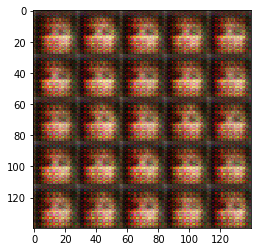

Epoch 1/1... Discriminator Loss: 2.0604... Generator Loss: 15.8226
Epoch 1/1... Discriminator Loss: 0.3873... Generator Loss: 7.8239
Epoch 1/1... Discriminator Loss: 0.1600... Generator Loss: 2.6107
Epoch 1/1... Discriminator Loss: 0.2286... Generator Loss: 2.9200
Epoch 1/1... Discriminator Loss: 0.1604... Generator Loss: 3.0294
Epoch 1/1... Discriminator Loss: 0.1249... Generator Loss: 2.8618
Epoch 1/1... Discriminator Loss: 0.1205... Generator Loss: 2.9665
Epoch 1/1... Discriminator Loss: 0.0719... Generator Loss: 3.3937
Epoch 1/1... Discriminator Loss: 0.3714... Generator Loss: 1.6017
Epoch 1/1... Discriminator Loss: 0.0902... Generator Loss: 3.3178


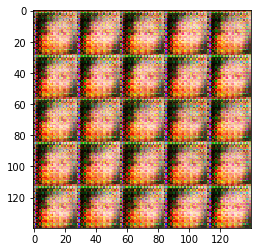

Epoch 1/1... Discriminator Loss: 0.0717... Generator Loss: 3.4379
Epoch 1/1... Discriminator Loss: 0.0613... Generator Loss: 3.4179
Epoch 1/1... Discriminator Loss: 0.0599... Generator Loss: 3.5556
Epoch 1/1... Discriminator Loss: 0.0904... Generator Loss: 3.4603
Epoch 1/1... Discriminator Loss: 0.1888... Generator Loss: 2.2483
Epoch 1/1... Discriminator Loss: 0.0569... Generator Loss: 3.6800
Epoch 1/1... Discriminator Loss: 0.3847... Generator Loss: 2.0091
Epoch 1/1... Discriminator Loss: 2.4482... Generator Loss: 8.3086
Epoch 1/1... Discriminator Loss: 0.3570... Generator Loss: 3.4616
Epoch 1/1... Discriminator Loss: 0.2845... Generator Loss: 3.4046


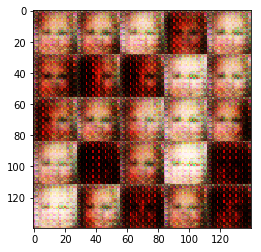

Epoch 1/1... Discriminator Loss: 0.4909... Generator Loss: 1.3303
Epoch 1/1... Discriminator Loss: 0.4731... Generator Loss: 7.8798
Epoch 1/1... Discriminator Loss: 0.2126... Generator Loss: 3.2902
Epoch 1/1... Discriminator Loss: 0.5869... Generator Loss: 7.6081
Epoch 1/1... Discriminator Loss: 1.4418... Generator Loss: 0.6678
Epoch 1/1... Discriminator Loss: 0.8558... Generator Loss: 1.6394
Epoch 1/1... Discriminator Loss: 0.6725... Generator Loss: 2.8973
Epoch 1/1... Discriminator Loss: 1.2694... Generator Loss: 0.5622
Epoch 1/1... Discriminator Loss: 2.3498... Generator Loss: 0.2117
Epoch 1/1... Discriminator Loss: 0.7090... Generator Loss: 1.9073


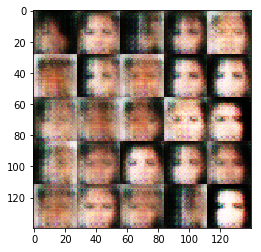

Epoch 1/1... Discriminator Loss: 1.2755... Generator Loss: 0.6202
Epoch 1/1... Discriminator Loss: 0.4478... Generator Loss: 1.7674
Epoch 1/1... Discriminator Loss: 0.6505... Generator Loss: 2.9635
Epoch 1/1... Discriminator Loss: 0.9084... Generator Loss: 0.9937
Epoch 1/1... Discriminator Loss: 0.7652... Generator Loss: 3.0438
Epoch 1/1... Discriminator Loss: 0.7818... Generator Loss: 1.1457
Epoch 1/1... Discriminator Loss: 1.2113... Generator Loss: 0.7180
Epoch 1/1... Discriminator Loss: 0.3523... Generator Loss: 3.2164
Epoch 1/1... Discriminator Loss: 0.3152... Generator Loss: 3.0156
Epoch 1/1... Discriminator Loss: 0.2846... Generator Loss: 2.6290


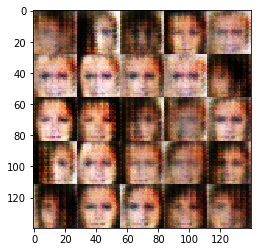

Epoch 1/1... Discriminator Loss: 0.6039... Generator Loss: 1.9079
Epoch 1/1... Discriminator Loss: 0.5739... Generator Loss: 1.8162
Epoch 1/1... Discriminator Loss: 0.4449... Generator Loss: 1.8325
Epoch 1/1... Discriminator Loss: 1.5212... Generator Loss: 0.3576
Epoch 1/1... Discriminator Loss: 0.4949... Generator Loss: 2.2202
Epoch 1/1... Discriminator Loss: 0.4268... Generator Loss: 1.8227
Epoch 1/1... Discriminator Loss: 0.5900... Generator Loss: 1.9157
Epoch 1/1... Discriminator Loss: 0.5912... Generator Loss: 3.1065
Epoch 1/1... Discriminator Loss: 0.6970... Generator Loss: 1.4522
Epoch 1/1... Discriminator Loss: 0.4803... Generator Loss: 2.2307


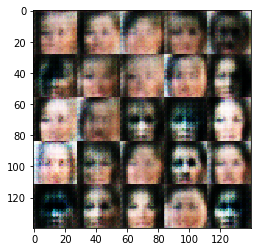

Epoch 1/1... Discriminator Loss: 0.7060... Generator Loss: 3.9128
Epoch 1/1... Discriminator Loss: 0.5149... Generator Loss: 1.8281
Epoch 1/1... Discriminator Loss: 1.1297... Generator Loss: 0.6075
Epoch 1/1... Discriminator Loss: 1.0930... Generator Loss: 0.7289
Epoch 1/1... Discriminator Loss: 0.6376... Generator Loss: 1.3064
Epoch 1/1... Discriminator Loss: 0.7368... Generator Loss: 1.1546
Epoch 1/1... Discriminator Loss: 0.5601... Generator Loss: 1.4615
Epoch 1/1... Discriminator Loss: 0.5295... Generator Loss: 1.6412
Epoch 1/1... Discriminator Loss: 0.5314... Generator Loss: 2.4999
Epoch 1/1... Discriminator Loss: 0.8911... Generator Loss: 1.1331


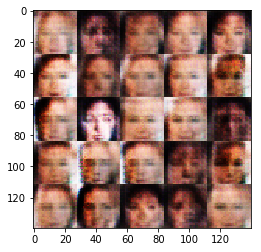

Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.5145
Epoch 1/1... Discriminator Loss: 0.4671... Generator Loss: 1.9332
Epoch 1/1... Discriminator Loss: 0.9366... Generator Loss: 1.0079
Epoch 1/1... Discriminator Loss: 0.4299... Generator Loss: 1.8121
Epoch 1/1... Discriminator Loss: 0.5614... Generator Loss: 4.1624
Epoch 1/1... Discriminator Loss: 0.2170... Generator Loss: 3.7656
Epoch 1/1... Discriminator Loss: 0.4936... Generator Loss: 1.9382
Epoch 1/1... Discriminator Loss: 0.6824... Generator Loss: 3.2566
Epoch 1/1... Discriminator Loss: 0.6390... Generator Loss: 1.3183
Epoch 1/1... Discriminator Loss: 0.5772... Generator Loss: 1.3264


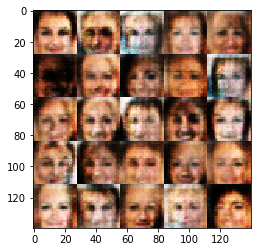

Epoch 1/1... Discriminator Loss: 1.1454... Generator Loss: 4.7301
Epoch 1/1... Discriminator Loss: 0.6228... Generator Loss: 1.1606
Epoch 1/1... Discriminator Loss: 0.8908... Generator Loss: 0.7929
Epoch 1/1... Discriminator Loss: 0.8863... Generator Loss: 0.8556
Epoch 1/1... Discriminator Loss: 0.8452... Generator Loss: 0.8232
Epoch 1/1... Discriminator Loss: 0.6799... Generator Loss: 1.4023
Epoch 1/1... Discriminator Loss: 0.5789... Generator Loss: 3.3280
Epoch 1/1... Discriminator Loss: 0.2842... Generator Loss: 2.8953
Epoch 1/1... Discriminator Loss: 0.5365... Generator Loss: 2.1393
Epoch 1/1... Discriminator Loss: 1.1402... Generator Loss: 0.7376


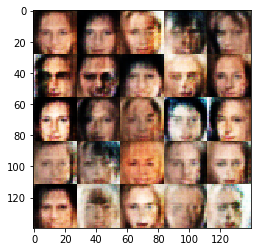

Epoch 1/1... Discriminator Loss: 0.3820... Generator Loss: 2.1482
Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 5.5303
Epoch 1/1... Discriminator Loss: 0.5173... Generator Loss: 1.3342
Epoch 1/1... Discriminator Loss: 0.4344... Generator Loss: 1.8779
Epoch 1/1... Discriminator Loss: 0.9628... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 0.7174... Generator Loss: 0.9956
Epoch 1/1... Discriminator Loss: 1.0935... Generator Loss: 0.6188
Epoch 1/1... Discriminator Loss: 0.7694... Generator Loss: 1.0265
Epoch 1/1... Discriminator Loss: 0.4875... Generator Loss: 4.9228
Epoch 1/1... Discriminator Loss: 0.5025... Generator Loss: 1.5571


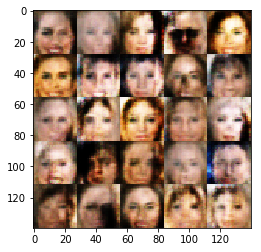

Epoch 1/1... Discriminator Loss: 0.2983... Generator Loss: 5.1257
Epoch 1/1... Discriminator Loss: 0.2660... Generator Loss: 3.2508
Epoch 1/1... Discriminator Loss: 0.1426... Generator Loss: 4.2432
Epoch 1/1... Discriminator Loss: 0.3775... Generator Loss: 1.5828
Epoch 1/1... Discriminator Loss: 0.5550... Generator Loss: 1.3096
Epoch 1/1... Discriminator Loss: 0.1855... Generator Loss: 2.5187
Epoch 1/1... Discriminator Loss: 1.8870... Generator Loss: 0.3022
Epoch 1/1... Discriminator Loss: 0.1305... Generator Loss: 3.1679
Epoch 1/1... Discriminator Loss: 0.1531... Generator Loss: 4.1753
Epoch 1/1... Discriminator Loss: 0.7835... Generator Loss: 0.8706


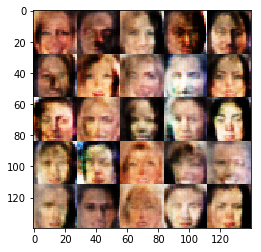

Epoch 1/1... Discriminator Loss: 0.1474... Generator Loss: 3.3116
Epoch 1/1... Discriminator Loss: 0.2117... Generator Loss: 6.1315
Epoch 1/1... Discriminator Loss: 0.2251... Generator Loss: 2.5217
Epoch 1/1... Discriminator Loss: 0.2123... Generator Loss: 5.3809
Epoch 1/1... Discriminator Loss: 0.8981... Generator Loss: 8.3981
Epoch 1/1... Discriminator Loss: 0.5423... Generator Loss: 1.2455
Epoch 1/1... Discriminator Loss: 0.2291... Generator Loss: 3.5116
Epoch 1/1... Discriminator Loss: 0.0923... Generator Loss: 3.7693
Epoch 1/1... Discriminator Loss: 0.3227... Generator Loss: 1.8205
Epoch 1/1... Discriminator Loss: 0.9652... Generator Loss: 7.7805


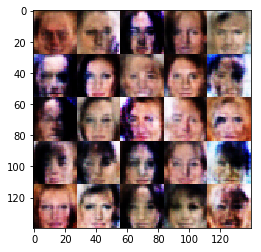

Epoch 1/1... Discriminator Loss: 0.0552... Generator Loss: 4.7190
Epoch 1/1... Discriminator Loss: 0.1339... Generator Loss: 3.0043
Epoch 1/1... Discriminator Loss: 1.0389... Generator Loss: 6.0865
Epoch 1/1... Discriminator Loss: 0.0530... Generator Loss: 6.8896
Epoch 1/1... Discriminator Loss: 0.3750... Generator Loss: 7.1248


In [24]:
batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.